In [3]:
def reconstruction_replacement(value, hook, autoencoder):
    # Rearrange to fit autoencoder
    int_val = rearrange(value, 'b s h -> (b s) h')
    # Run through the autoencoder
    reconstruction = autoencoder.predict(int_val)
    batch, seq_len, hidden_size = value.shape
    reconstruction = rearrange(reconstruction, '(b s) h -> b s h', b=batch, s=seq_len)
    return reconstruction

def reconstruction_acquirement(value, hook, autoencoder, sum_mse):
    # Rearrange to fit autoencoder
    int_val = rearrange(value, 'b s h -> (b s) h')
    # Run through the autoencoder
    reconstruction = autoencoder.predict(int_val)
    batch, seq_len, hidden_size = value.shape
    reconstruction = rearrange(reconstruction, '(b s) h -> b s h', b=batch, s=seq_len)
    sum_mse.add_((reconstruction - value).pow(2).sum())

def reconstruction_no_outliers(value, hook, autoencoder, outliers):
    # Rearrange to fit autoencoder
    int_val = rearrange(value, 'b s h -> (b s) h')
    # Run through the autoencoder
    reconstruction = autoencoder.predict(int_val)
    batch, seq_len, hidden_size = value.shape
    reconstruction = rearrange(reconstruction, '(b s) h -> b s h', b=batch, s=seq_len)
    # Replace outliers with original values
    reconstruction[:, :, outliers] = value[:, :, outliers]
    return reconstruction

def find_outliers(dataset, cache_name, model, num_outlier_dims=2):
    device = model.cfg.device
    batch_size = 32
    with torch.no_grad(), dataset.formatted_as("pt"):
        dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
        # Just take the first batch
        first_batch = next(iter(dl))
        _, cache = model.run_with_cache(first_batch.to(device))
        layer_activations = rearrange(cache[cache_name], "b s h -> (b s) h").cpu()
        outlier_dims = layer_activations.abs().max(0).values.topk(num_outlier_dims).indices
    return outlier_dims

def get_original_perplexity(model, dataset):
    total_loss = 0
    batch_size = 32
    with torch.no_grad(), dataset.formatted_as("pt"):
        dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
        for i, batch in enumerate(dl):
            loss = model(batch.to(device), return_type="loss")
            total_loss += loss.item()
        # Average
        avg_neg_log_likelihood = total_loss / len(dl)

        # Convert to tensor
        avg_neg_log_likelihood = torch.tensor(avg_neg_log_likelihood, device=device)

        # Exponentiate to compute perplexity
        perplexity = torch.exp(avg_neg_log_likelihood)
        print(f"Perplexity for original model: {perplexity.item():.2f}")
    return perplexity.item()

def get_perplexity(autoencoder, model, dataset, forward_hook):
    device = model.cfg.device
    model = model.eval()
    batch_size = 32
    # autoencoder.to_device(device)
    total_loss = 0
    with torch.no_grad(), dataset.formatted_as("pt"):
        dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
        for i, batch in enumerate(dl):
            loss = model.run_with_hooks(
                batch.to(device), 
                return_type="loss",
                fwd_hooks=[forward_hook]
                )
            total_loss += loss.item()
    # Average
    avg_neg_log_likelihood = total_loss / len(dl)

    # Convert to tensor
    avg_neg_log_likelihood = torch.tensor(avg_neg_log_likelihood, device=device)

    # Exponentiate to compute perplexity
    perplexity = torch.exp(avg_neg_log_likelihood)
    print(f"Perplexity {perplexity.item():.2f}")
    return perplexity.item()

def get_MSE(autoencoder, model, dataset, cache_name, device):
    sum_mse = torch.empty((1,), device=device)
    forward_hook = (cache_name, partial(reconstruction_acquirement, autoencoder=autoencoder, sum_mse=sum_mse))
    device = model.cfg.device
    model = model.eval()
    batch_size = 32
    # autoencoder.to_device(device)
    # total_loss = 0
    total_rows = 0
    with torch.no_grad(), dataset.formatted_as("pt"):
        dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
        for i, batch in enumerate(dl):
            _ = model.run_with_hooks(
                batch.to(device), 
                return_type=None,
                fwd_hooks=[forward_hook]
                )
            # total_loss += loss.item()
            total_rows += batch.shape[0]
    # Average
    mse = sum_mse / total_rows
    return mse.item()

def get_l2ratio(autoencoder, model, dataset, cache_name, device, filter=None):
    res_stream = []
    reconst = []
    # exp_var = ExplainedVariance()
    
    nfeatures = autoencoder.encoder.shape[0]
    
    if filter is None:
        filter = torch.ones((nfeatures,), device=device)
    
    if max(filter) > 1:
        # filter is currently [id_1, id_2, id_3, ...]
        # must change filter to binary form [0,1,0,0,0,1,0,1,1...]
        new_filter = torch.zeros((nfeatures,), device=device)
        for f in filter:
            new_filter[f] = 1
        filter = new_filter
    
    def reconstruction_acquirement(value, hook):
        # Rearrange to fit autoencoder
        # print(value.shape)
        int_val = rearrange(value, 'b s h -> (b s) h')
        # Run through the autoencoder
        f = autoencoder.encode(int_val) * filter
        reconstruction = autoencoder.decode(f)
        batch, seq_len, hidden_size = value.shape
        reconstruction = rearrange(reconstruction, '(b s) h -> b s h', b=batch, s=seq_len)
        # exp_var.update(reconstruction, value)
        res_stream.append(value)
        reconst.append(reconstruction)
        return reconstruction

    forward_hook = (cache_name, (reconstruction_acquirement))
    device = model.cfg.device
    model = model.eval()
    batch_size = 32
    # autoencoder.to_device(device)
    total_loss = 0
    total_rows = 0
    
    sum_l2_ratio = 0
    with torch.no_grad(), dataset.formatted_as("pt"):
        dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
        for i, batch in enumerate(dl):
            model.run_with_hooks(
                batch.to(device), 
                return_type=None,
                fwd_hooks=[forward_hook]
                )

            sum_l2_ratio += (reconst[-1].norm(p=2, dim=-1)/res_stream[-1].norm(p=2, dim=-1)).mean()
            res_stream = []
            reconst = []
            
    l2_ratio = sum_l2_ratio/len(dl)
    return l2_ratio

def get_perplexity_and_mse(autoencoder, model, dataset, cache_name, device, filter=None):
    sum_mse = torch.zeros((1,), device=device)
    sparsity = torch.zeros((1,), device=device)
    res_stream = []
    reconst = []
    # exp_var = ExplainedVariance()
    
    nfeatures = autoencoder.encoder.shape[0]
    
    if filter is None:
        filter = torch.ones((nfeatures,), device=device)
    
    if max(filter) > 1:
        # filter is currently [id_1, id_2, id_3, ...]
        # must change filter to binary form [0,1,0,0,0,1,0,1,1...]
        new_filter = torch.zeros((nfeatures,), device=device)
        for f in filter:
            new_filter[f] = 1
        filter = new_filter
    
    def reconstruction_replacement_acquirement(value, hook):
        # Rearrange to fit autoencoder
        # print(value.shape)
        int_val = rearrange(value, 'b s h -> (b s) h')
        # Run through the autoencoder
        f = autoencoder.encode(int_val) * filter
        reconstruction = autoencoder.decode(f)
        batch, seq_len, hidden_size = value.shape
        reconstruction = rearrange(reconstruction, '(b s) h -> b s h', b=batch, s=seq_len)
        sum_mse.add_((reconstruction - value).pow(2).sum())
        sparsity.add_((f > 0).sum())
        
        # exp_var.update(reconstruction, value)
        res_stream.append(value)
        reconst.append(reconstruction)
        
        return reconstruction

    forward_hook = (cache_name, (reconstruction_replacement_acquirement))
    device = model.cfg.device
    model = model.eval()
    batch_size = 32
    # autoencoder.to_device(device)
    total_loss = 0
    total_rows = 0
    sum_l2_ratio = 0
    with torch.no_grad(), dataset.formatted_as("pt"):
        dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
        for i, batch in enumerate(dl):
            loss = model.run_with_hooks(
                batch.to(device), 
                return_type="loss",
                fwd_hooks=[forward_hook]
                )
            total_loss += loss.item() * batch.shape[0]
            total_rows += batch.shape[0]
            sum_l2_ratio += (reconst[-1].norm(p=2, dim=-1)/res_stream[-1].norm(p=2, dim=-1)).mean()
            res_stream = []
            reconst = []
    # Average
    mse = sum_mse / total_rows / 256 / 512
    sparsity = sparsity / total_rows / 256
    
    l2_ratio = sum_l2_ratio/len(dl)
    
    avg_neg_log_likelihood = total_loss / total_rows

    # Convert to tensor
    avg_neg_log_likelihood = torch.tensor(avg_neg_log_likelihood, device=device)

    # Exponentiate to compute perplexity
    perplexity = torch.exp(avg_neg_log_likelihood)
    print(f"MSE {mse.item():.4f}")
    print(f"Perplexity {perplexity.item():.2f}")
    return mse.item(), sparsity.item(), perplexity.item(), l2_ratio.item() #, exp_var.compute()

def download_dataset(dataset_name, max_length=256, num_datapoints=None):
    dataset = load_dataset(dataset_name, split="train")
    if(num_datapoints):
        split_text = f"train[:{num_datapoints}]"
    else:
        split_text = "train"
    dataset = load_dataset(dataset_name, split=split_text).map(
        lambda x: model.tokenizer(x['text']),
        batched=True,
    ).filter(
        lambda x: len(x['input_ids']) > max_length
    ).map(
        lambda x: {'input_ids': x['input_ids'][:max_length]}
    )
    return dataset

In [4]:
#Change these settings to load the correct autoencoder
from transformer_lens import HookedTransformer
import torch
import numpy as np
from torch.utils.data import DataLoader
from datasets import Dataset, load_dataset
from tqdm.auto import tqdm
from functools import partial
from einops import rearrange
# layer = 2
layers = [0,1,2,3,4,5]
l1_alphas = [2e-3]
setting = "residual"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

cache_names = []

for layer in layers:
    if setting == "residual":
        cache_name = f"blocks.{layer}.hook_resid_post"
    elif setting == "mlp":
        cache_name = f"blocks.{layer}.mlp.hook_post"
    else:
        raise NotImplementedError
    cache_names.append(cache_name)
    
# gpt2_autoencoders = torch.load("/mnt/ssd-cluster/gpt2small/tied_residual_l2_r8/_31/learned_dicts.pt")
# pythia_autoencoders = torch.load("/mnt/ssd-cluster/longrun2408/tied_residual_l2_r6/_31/learned_dicts.pt")

In [5]:
# load autoencoders
modes = ["sae", "baseline", "dnorotation", "dfree", "scale", "enorotation", "efree", "norotation"]
# modes = ["sae", "dfree"]
autoencoders = []
for layer in layers:
    l1_variants = []
    
    for l1 in ((l1_alphas)):  
        mode_tsaes = []
        mode_opts = []
        for mode in modes:
            if mode == "sae":
                mode_tsae = torch.load(f"trained_models/checkpoint5/base_sae_70m_{layer}_{l1}.pt")
                mode_tsaes.append(mode_tsae)
            # elif mode == "baseline":
            #     mode_tsae = torch.load(f"trained_models/base_retrain_70m/base_sae_70m_{layer}_{l1}.pt")
            #     mode_tsaes.append(mode_tsae)
            else:
                mode_tsae = torch.load(f"trained_models/base_autoTED_70m/base_autoTED_70m_{mode}_{layer}_{l1}.pt")
                mode_tsaes.append(mode_tsae)
        
        l1_variants.append(mode_tsaes)
    autoencoders.append(l1_variants)


In [ ]:
weak_features = torch.load("weak_features.p").to(device)
transition_features = torch.load("transition_features.p").to(device)
vip_features = torch.load("vip_features.p").to(device)
non_weak_features = torch.logical_or(transition_features, vip_features)

In [ ]:
vip_features.sum()

In [19]:
# Get dataset
model_name = "EleutherAI/pythia-70m"
model = HookedTransformer.from_pretrained(model_name, device=device)
dataset = download_dataset("Elriggs/openwebtext-100k", max_length=256, num_datapoints=4000) # num tokens = max_length * num_datapoints
print(len(dataset))
# Get top-N outlier dims
outlier_dims = find_outliers(dataset, cache_name, model, num_outlier_dims=2)
# Get original model perplexity 
original_perplexity = get_original_perplexity(model, dataset)
# Get perplexity for all autoencoders

# num_autoencoders = len(autoencoders)
filters = [None,]
all_perplexities2 = np.zeros((len(layers),len(l1_alphas),len(modes), len(filters)))
all_mses2 = np.zeros((len(layers),len(l1_alphas),len(modes), len(filters)))
all_sparsities2 = np.zeros((len(layers),len(l1_alphas),len(modes), len(filters)))
all_l2_ratios = np.zeros((len(layers),len(l1_alphas),len(modes), len(filters)))

for layer in range(len(layers)):    
    cache_name = cache_names[layer]
    for l1 in range(len(l1_alphas)):
        for m_id in range(len(modes)):
            for filter_id in range(len(filters)):
                filter = filters[filter_id]
            
                autoencoder = autoencoders[layer][l1][m_id]#.to(device)
                # for i, (autoencoder, hyperparam) in enumerate(all_autoencoders):
                # forward_hook = (cache_name, partial(reconstruction_no_outliers, autoencoder=autoencoder, outliers = outlier_dims))
                # forward_hook = (cache_name, partial(reconstruction_replacement, autoencoder=autoencoder))
                m, s, p, l2_r = get_perplexity_and_mse(autoencoder, model, dataset, cache_name, device, filter=filter)
                # m = get_MSE(autoencoder, model, dataset, cache_name, device)
                all_mses2[layer][l1][m_id][filter_id] = m
                all_perplexities2[layer][l1][m_id][filter_id] = p
                all_sparsities2[layer][l1][m_id][filter_id] = s
                all_l2_ratios[layer][l1][m_id][filter_id] = l2_r

Using pad_token, but it is not set yet.


Loaded pretrained model EleutherAI/pythia-70m into HookedTransformer


Found cached dataset parquet (/root/.cache/huggingface/datasets/Elriggs___parquet/Elriggs--openwebtext-100k-79076ecafee8a6d5/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Found cached dataset parquet (/root/.cache/huggingface/datasets/Elriggs___parquet/Elriggs--openwebtext-100k-79076ecafee8a6d5/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Loading cached processed dataset at /root/.cache/huggingface/datasets/Elriggs___parquet/Elriggs--openwebtext-100k-79076ecafee8a6d5/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-687da6de8534d5fe.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/Elriggs___parquet/Elriggs--openwebtext-100k-79076ecafee8a6d5/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-b16c84cbf4c68eea.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/Elriggs___parquet/Elriggs--openwebtext-100k-79076ecafee8a6d5/0.0.0/2a3b91f

3649
Perplexity for original model: 39.63
MSE 0.0159
Perplexity 93.84
MSE 0.0159
Perplexity 94.16
MSE 0.0155
Perplexity 82.83
MSE 0.0154
Perplexity 78.77
MSE 0.0155
Perplexity 83.01
MSE 0.0162
Perplexity 79.56
MSE 0.0096
Perplexity 58.84
MSE 0.0157
Perplexity 80.40
MSE 0.0270
Perplexity 76.21
MSE 0.0269
Perplexity 75.66
MSE 0.0260
Perplexity 71.59
MSE 0.0257
Perplexity 69.53
MSE 0.0260
Perplexity 71.79
MSE 0.0240
Perplexity 66.10
MSE 0.0025
Perplexity 41.01
MSE 0.0230
Perplexity 64.47
MSE 0.0431
Perplexity 85.29
MSE 0.0431
Perplexity 84.66
MSE 0.0394
Perplexity 79.28
MSE 0.0379
Perplexity 75.22
MSE 0.0394
Perplexity 79.49
MSE 0.0309
Perplexity 72.54
MSE 0.0018
Perplexity 40.27
MSE 0.0296
Perplexity 70.94
MSE 0.0507
Perplexity 85.11
MSE 0.0507
Perplexity 85.24
MSE 0.0472
Perplexity 80.26
MSE 0.0454
Perplexity 75.72
MSE 0.0472
Perplexity 80.38
MSE 0.0370
Perplexity 65.51
MSE 0.0012
Perplexity 39.88
MSE 0.0352
Perplexity 63.61
MSE 0.0645
Perplexity 67.58
MSE 0.0647
Perplexity 67.88
MSE 0.

In [15]:
# num_autoencoders = len(autoencoders)
filters = [None,]
dataset = download_dataset("Elriggs/openwebtext-100k", max_length=256, num_datapoints=4000) # num tokens = max_length * num_datapoints

all_l2_ratios = np.zeros((len(layers),len(l1_alphas),len(modes), len(filters)))

for layer in range(len(layers)):    
    cache_name = cache_names[layer]
    for l1 in range(len(l1_alphas)):
        for m_id in range(len(modes)):
            for filter_id in range(len(filters)):
                filter = filters[filter_id]
            
                autoencoder = autoencoders[layer][l1][m_id]#.to(device)
                # for i, (autoencoder, hyperparam) in enumerate(all_autoencoders):
                # forward_hook = (cache_name, partial(reconstruction_no_outliers, autoencoder=autoencoder, outliers = outlier_dims))
                # forward_hook = (cache_name, partial(reconstruction_replacement, autoencoder=autoencoder))
                l2_r = get_l2ratio(autoencoder, model, dataset, cache_name, device, filter=filter)
                # m = get_MSE(autoencoder, model, dataset, cache_name, device)
                all_l2_ratios[layer][l1][m_id][filter_id] = l2_r

Found cached dataset parquet (/root/.cache/huggingface/datasets/Elriggs___parquet/Elriggs--openwebtext-100k-79076ecafee8a6d5/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Found cached dataset parquet (/root/.cache/huggingface/datasets/Elriggs___parquet/Elriggs--openwebtext-100k-79076ecafee8a6d5/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3649 [00:00<?, ? examples/s]

In [22]:
all_perplexities2.shape

(6, 1, 8, 1)

In [23]:
np.mean(all_perplexities2, axis=(0,1,2))

array([68.73281233])

In [24]:
original_perplexity

39.62510681152344

In [16]:
nmodes = len(modes)-1
nice_name_dict = {
    "sae": "Original",
    "baseline": "Baseline",
    "dnorotation": "Unrotated Decoder", 
    "dfree": "Decoder", 
    "scale": "Scale", 
    "enorotation": "Unrotated Encoder", 
    "efree": "Encoder", 
    "norotation": "Unrotated All"
}
nice_modes = [nice_name_dict[m] for m in modes]

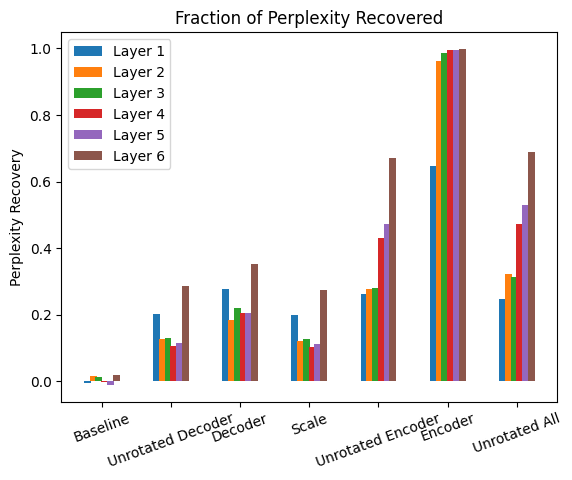

In [37]:
#Plot all_model_perplexities - all_model_perplexities2
import matplotlib.pyplot as plt
# model_perplexity_diff = np.array(all_model_perplexities) - np.array(all_model_perplexities2)

for layer in layers:
    filtered_perps = all_perplexities2[layer,0,1:]
    sae_perp = all_perplexities2[layer][0][0]
    recovered_perps = (sae_perp - filtered_perps)/(sae_perp - original_perplexity)
    # print(recovered_perps.shape)

    xs = np.arange(len(modes[1:])) + layer/(2*len(layers)) - (len(layers)-1)/(4*len(layers))
    plt.bar(xs,recovered_perps[:,0], width=0.1)
    
xs = np.arange(len(modes[1:]))

plt.legend([f"Layer {l+1}" for l in layers])
plt.title("Fraction of Perplexity Recovered")
# plt.xlabel("Autoencoder Mode")
plt.ylabel("Perplexity Recovery")
plt.xticks(xs, nice_modes[1:], rotation=20)
# set ylimit to 10
# plt.ylim(0, 1)
plt.show()

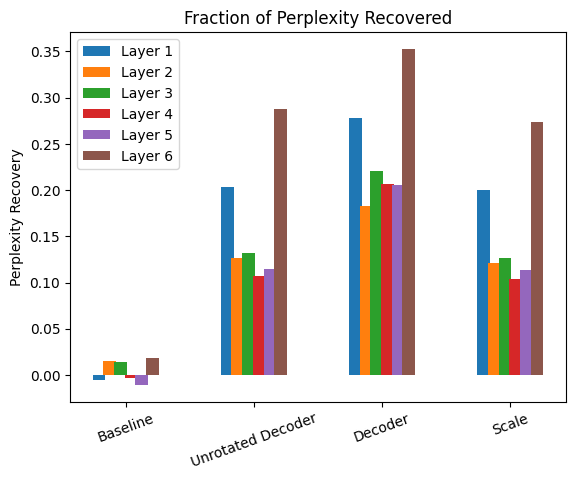

In [36]:
#Plot all_model_perplexities - all_model_perplexities2
import matplotlib.pyplot as plt
# model_perplexity_diff = np.array(all_model_perplexities) - np.array(all_model_perplexities2)

for layer in layers:
    filtered_perps = all_perplexities2[layer,0,1:5]
    sae_perp = all_perplexities2[layer][0][0]
    recovered_perps = (sae_perp - filtered_perps)/(sae_perp - original_perplexity)
    # print(recovered_perps.shape)

    xs = np.arange(len(modes[1:5])) + layer/(2*len(layers)) - (len(layers)-1)/(4*len(layers))
    plt.bar(xs,recovered_perps[:,0], width=0.1)
    
xs = np.arange(len(modes[1:5]))

plt.legend([f"Layer {l+1}" for l in layers])
plt.title("Fraction of Perplexity Recovered")
# plt.xlabel("Autoencoder Mode")
plt.ylabel("Perplexity Recovery")
plt.xticks(xs, nice_modes[1:5], rotation=20)
# set ylimit to 10
# plt.ylim(0, 1)
# plt.xlim((-0.5,3.5))
plt.show()

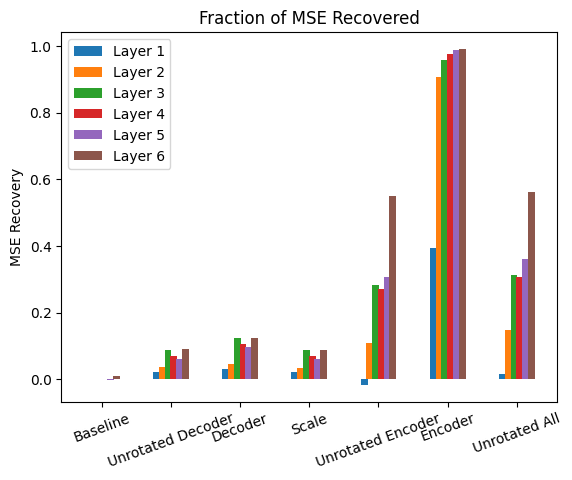

In [38]:
#Plot all_model_perplexities - all_model_perplexities2
import matplotlib.pyplot as plt
# model_perplexity_diff = np.array(all_model_perplexities) - np.array(all_model_perplexities2)

for layer in layers:
    filtered_mses = all_mses2[layer,0,1:]
    sae_mse = all_mses2[layer][0][0]
    recovered_mses = (sae_mse - filtered_mses)/(sae_mse)

    xs = np.arange(len(modes[1:])) + layer/(2*len(layers)) - (len(layers)-1)/(4*len(layers))
    plt.bar(xs,recovered_mses[:,0], width=0.1)
    
xs = np.arange(len(modes[1:]))

plt.legend([f"Layer {l+1}" for l in layers])
plt.title("Fraction of MSE Recovered")
# plt.xlabel("Autoencoder Mode")
plt.ylabel("MSE Recovery")
plt.xticks(xs, nice_modes[1:], rotation=20)
# set ylimit to 10
# plt.ylim(0, 1)
plt.show()

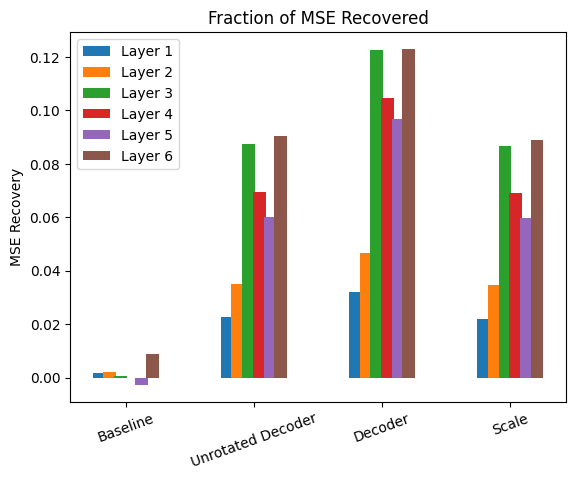

In [39]:
#Plot all_model_perplexities - all_model_perplexities2
import matplotlib.pyplot as plt
# model_perplexity_diff = np.array(all_model_perplexities) - np.array(all_model_perplexities2)

for layer in layers:
    filtered_mses = all_mses2[layer,0,1:5]
    sae_mse = all_mses2[layer][0][0]
    recovered_mses = (sae_mse - filtered_mses)/(sae_mse)

    xs = np.arange(len(modes[1:5])) + layer/(2*len(layers)) - (len(layers)-1)/(4*len(layers))
    plt.bar(xs,recovered_mses[:,0], width=0.1)
    
xs = np.arange(len(modes[1:5]))

plt.legend([f"Layer {l+1}" for l in layers])
plt.title("Fraction of MSE Recovered")
# plt.xlabel("Autoencoder Mode")
plt.ylabel("MSE Recovery")
plt.xticks(xs, nice_modes[1:5], rotation=20)
# set ylimit to 10
# plt.ylim(0, 1)
plt.show()

In [31]:
all_sparsities2[:,0,:,0]

array([[  13.34276581,    9.47817039,   13.34276581,   13.34276581,
          13.34276581,   58.09614182,  669.53289795,   78.77344513],
       [  16.80053902,   15.54374313,   16.80053902,   16.80053902,
          16.80053902,   79.16474915, 1024.96777344,  160.00474548],
       [  45.52205276,   45.70195007,   45.52205276,   45.52205276,
          45.52205276,  253.20996094, 1169.39904785,  333.39581299],
       [  38.52734756,   38.70572662,   38.52734756,   38.52734756,
          38.52734756,  286.12579346, 1206.58251953,  368.7572937 ],
       [  49.77802658,   49.57460785,   49.77802658,   49.77802658,
          49.77802658,  433.04598999, 1309.86206055,  572.72198486],
       [  80.65522766,   86.07478333,   80.65522766,   80.65522766,
          80.65522766,  984.21533203, 1340.12878418, 1085.93457031]])

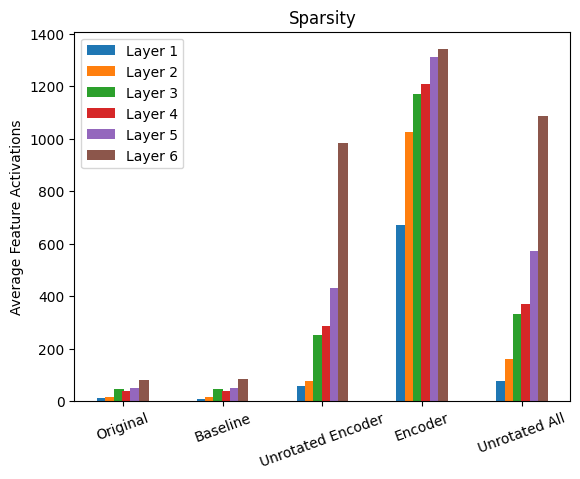

In [49]:
#Plot all_model_perplexities - all_model_perplexities2
import matplotlib.pyplot as plt
# model_perplexity_diff = np.array(all_model_perplexities) - np.array(all_model_perplexities2)
filter = [0,1,5,6,7]
filtered_modes = [modes[f] for f in filter]
filtered_nice_modes = [nice_modes[f] for f in filter]
for layer in layers:
    filtered_mses = all_sparsities2[layer,0,filter]
    xs = np.arange(len(filtered_modes)) + layer/(2*len(layers)) - (len(layers)-1)/(4*len(layers))
    plt.bar(xs,filtered_mses[:,0], width=0.1)
    
xs = np.arange(len(filtered_modes))

plt.legend([f"Layer {l+1}" for l in layers])
plt.title("Sparsity")
# plt.xlabel("Autoencoder Mode")
plt.ylabel("Average Feature Activations")
plt.xticks(xs, filtered_nice_modes, rotation=20)
# set ylimit to 10
# plt.ylim(0, 1)
plt.show()

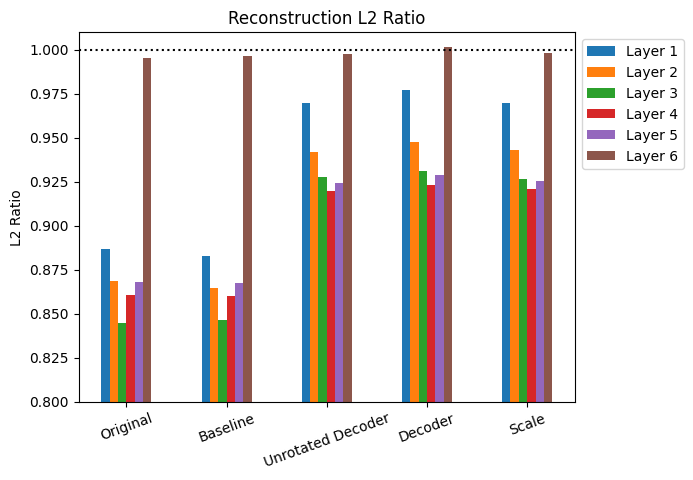

In [18]:
#Plot all_model_perplexities - all_model_perplexities2
import matplotlib.pyplot as plt
# model_perplexity_diff = np.array(all_model_perplexities) - np.array(all_model_perplexities2)
filter = [0,1,2,3,4]
filtered_modes = [modes[f] for f in filter]
filtered_nice_modes = [nice_modes[f] for f in filter]
for layer in layers:
    filtered_mses = all_l2_ratios[layer,0,filter]
    xs = np.arange(len(filtered_modes)) + layer/(2*len(layers)) - (len(layers)-1)/(4*len(layers))
    plt.bar(xs,filtered_mses[:,0], width=0.5/len(layers))
    
xs = np.arange(len(filtered_modes))

plt.legend([f"Layer {l+1}" for l in layers], bbox_to_anchor=(1., 1.0))
plt.axhline(1, color="black", linestyle=":")
plt.title("Reconstruction L2 Ratio")
# plt.xlabel("Autoencoder Mode")
plt.ylabel("L2 Ratio")
plt.xticks(xs, filtered_nice_modes, rotation=20)
# set ylimit to 10
plt.ylim(0.8, 1.01)
plt.show()

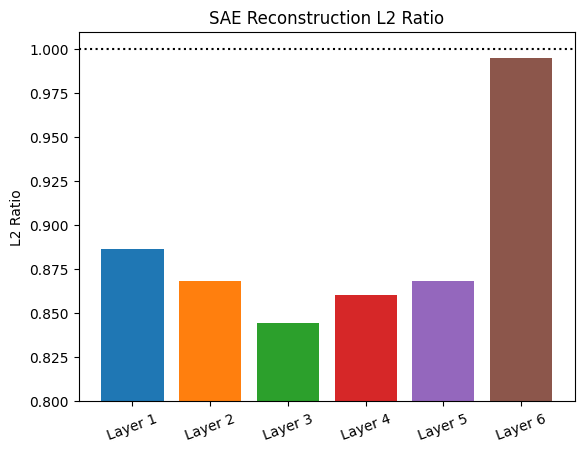

In [12]:
vals = [0.8865, 0.8683, 0.8447, 0.8606, 0.8681, 0.9951]
xs = np.arange(len(vals))
import matplotlib.pyplot as plt

for i in range(len(vals)):
    plt.bar(x=xs[i],height=vals[i])

# plt.legend([f"Layer {l+1}" for l in layers], bbox_to_anchor=(1., 1.0))
plt.axhline(1, color="black", linestyle=":")
plt.title("SAE Reconstruction L2 Ratio")
# plt.xlabel("Autoencoder Mode")
plt.ylabel("L2 Ratio")
plt.xticks(xs, [f"Layer {l+1}" for l in layers], rotation=20)
# set ylimit to 10
plt.ylim(0.8, 1.01)
plt.show()

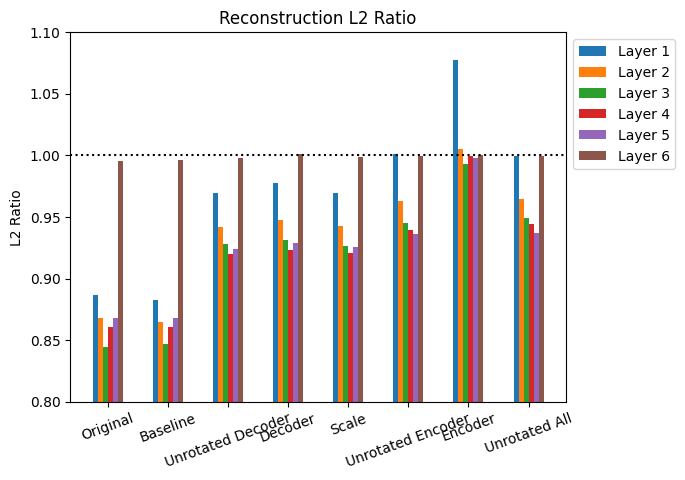

In [112]:
#Plot all_model_perplexities - all_model_perplexities2
import matplotlib.pyplot as plt
# model_perplexity_diff = np.array(all_model_perplexities) - np.array(all_model_perplexities2)
filter = [0,1,2,3,4,5,6,7]
filtered_modes = [modes[f] for f in filter]
filtered_nice_modes = [nice_modes[f] for f in filter]
for layer in layers:
    filtered_mses = all_l2_ratios[layer,0,filter]
    xs = np.arange(len(filtered_modes)) + layer/(2*len(layers)) - (len(layers)-1)/(4*len(layers))
    plt.bar(xs,filtered_mses[:,0], width=0.5/len(layers))
    
xs = np.arange(len(filtered_modes))

plt.legend([f"Layer {l+1}" for l in layers], bbox_to_anchor=(1., 1.0))
plt.axhline(1, color="black", linestyle=":")
plt.title("Reconstruction L2 Ratio")
# plt.xlabel("Autoencoder Mode")
plt.ylabel("L2 Ratio")
plt.xticks(xs, filtered_nice_modes, rotation=20)
# set ylimit to 10
plt.ylim(0.8, 1.1)
plt.show()

In [61]:
torch.save(all_mses2, "all_mses.pt")
torch.save(all_perplexities2, "all_perplexities.pt")
torch.save(all_sparsities2, "all_sparsities.pt")

In [62]:
all_mses2.shape

(6, 1, 8, 1)

In [64]:
modes

['sae',
 'baseline',
 'dnorotation',
 'dfree',
 'scale',
 'enorotation',
 'efree',
 'norotation']

In [32]:
all_perplexities2[:,0,:,0]

array([[93.84111786, 94.15554047, 82.82800293, 78.7700882 , 83.00726318,
        79.55621338, 58.84109879, 80.40077972],
       [76.2103653 , 75.65581512, 71.59243011, 69.52532959, 71.78831482,
        66.10466766, 41.00886536, 64.47253418],
       [85.29013062, 84.66215515, 79.28151703, 75.21804047, 79.48822784,
        72.54124451, 40.26699448, 70.94407654],
       [85.1100769 , 85.24386597, 80.25740814, 75.71659088, 80.37637329,
        65.50631714, 39.88204193, 63.61417007],
       [67.58003998, 67.88152313, 64.36398315, 61.82581329, 64.41558838,
        54.38971329, 39.80836105, 52.76872635],
       [73.16442871, 72.53886414, 63.52308655, 61.33476639, 63.98733902,
        50.66041946, 39.68813324, 50.08654785]])

In [33]:
all_sparsities2[:,0,:,0]

array([[  13.34276581,    9.47817039,   13.34276581,   13.34276581,
          13.34276581,   58.09614182,  669.53289795,   78.77344513],
       [  16.80053902,   15.54374313,   16.80053902,   16.80053902,
          16.80053902,   79.16474915, 1024.96777344,  160.00474548],
       [  45.52205276,   45.70195007,   45.52205276,   45.52205276,
          45.52205276,  253.20996094, 1169.39904785,  333.39581299],
       [  38.52734756,   38.70572662,   38.52734756,   38.52734756,
          38.52734756,  286.12579346, 1206.58251953,  368.7572937 ],
       [  49.77802658,   49.57460785,   49.77802658,   49.77802658,
          49.77802658,  433.04598999, 1309.86206055,  572.72198486],
       [  80.65522766,   86.07478333,   80.65522766,   80.65522766,
          80.65522766,  984.21533203, 1340.12878418, 1085.93457031]])

In [34]:
all_mses2[:,0,:,0]/512

array([[3.10486830e-05, 3.09936950e-05, 3.03481884e-05, 3.00568536e-05,
        3.03632987e-05, 3.15789475e-05, 1.87901951e-05, 3.06010479e-05],
       [5.26766962e-05, 5.25736796e-05, 5.08224111e-05, 5.02177427e-05,
        5.08497178e-05, 4.69020633e-05, 4.94948881e-06, 4.48513820e-05],
       [8.42544832e-05, 8.41892543e-05, 7.69005928e-05, 7.39414390e-05,
        7.69525650e-05, 6.04433881e-05, 3.51857966e-06, 5.79100051e-05],
       [9.90964400e-05, 9.90904227e-05, 9.22277104e-05, 8.87173082e-05,
        9.22663603e-05, 7.22729965e-05, 2.30417186e-06, 6.87178181e-05],
       [1.25930703e-04, 1.26271087e-04, 1.18338015e-04, 1.13758644e-04,
        1.18420750e-04, 8.74654215e-05, 1.41966984e-06, 8.06762255e-05],
       [2.27935132e-04, 2.25914933e-04, 2.07287711e-04, 1.99904855e-04,
        2.07634279e-04, 1.02833030e-04, 2.02267393e-06, 1.00206096e-04]])

In [35]:
all_l2_ratios[:,0,:,0]

array([[0.88651067, 0.88265681, 0.96966952, 0.9771778 , 0.96961558,
        1.00088096, 1.07712054, 0.9992283 ],
       [0.86834979, 0.86482674, 0.94198418, 0.9477061 , 0.94289881,
        0.96282816, 1.0050149 , 0.96493536],
       [0.84479147, 0.84664428, 0.92782229, 0.93124998, 0.92650181,
        0.94474041, 0.99287522, 0.94878966],
       [0.86063075, 0.86025149, 0.91976118, 0.92301691, 0.92104489,
        0.93962854, 0.9996103 , 0.94431955],
       [0.86816871, 0.86758447, 0.92401087, 0.92854148, 0.92520702,
        0.93626899, 0.99812233, 0.93662643],
       [0.9951911 , 0.99627066, 0.99745929, 1.00137651, 0.99840009,
        0.99960637, 1.00008297, 0.99943769]])

In [29]:
for i in [0,1,2,3,4,5]:
    avg_mse_change = 1 - (all_mses2[:,0,[i],0] / all_mses2[:,0,[0],0]).mean()
    print(avg_mse_change)

0.0
0.0017869456573396114
0.06087251772133351
0.08756620415995753
0.060174288370891005
0.25002209621558824


In [28]:
for i in [0,1,2,3,4,5]:
    avg_perp_change = (all_perplexities2[:,0,[0],0] - all_perplexities2[:,0,[i],0])/(all_perplexities2[:,0,[0],0] - original_perplexity)
    print(avg_perp_change.mean())

0.0
0.0046726269219511335
0.1616889366494361
0.24105646038090142
0.15644046741265558
0.39878298262199546


In [ ]:
#Plot all_model_perplexities - all_model_perplexities2
import matplotlib.pyplot as plt
model_perplexity_diff = np.array(all_model_perplexities) - np.array(all_model_perplexities2)
plt.plot(model_perplexity_diff.T)
plt.legend(models)
plt.title("Perplexity difference between reconstruction-top-2-outliers and reconstructed model")
plt.xlabel("Autoencoder")
plt.ylabel("Perplexity difference")
# set ylimit to 10
plt.ylim(0, 10)
plt.show()

In [ ]:
#Plot the pythia perplexities & gpts
plt.plot(all_model_perplexities2[0], label="GPT2-top-2-outliers", color="orange")
plt.plot(all_model_perplexities[0], label="GPT2", linestyle="--", color="orange")
plt.plot(all_model_perplexities2[1], label="Pythia-top-2-outliers", color="blue")
plt.plot(all_model_perplexities[1], label="Pythia", linestyle="--", color="blue")
plt.legend()
plt.title("Perplexity of GPT2 and Pythia with and without top-2-outliers")
plt.xlabel("Autoencoder")
plt.ylabel("Perplexity")
plt.ylim(20, 80)
plt.show()

In [ ]:
model_perplexity_diff

In [ ]:
all_model_perplexities # 0

In [ ]:
all_model_perplexities # 1

In [ ]:
all_model_perplexities # 2

In [ ]:
all_model_perplexities# 10

In [ ]:
outlier_dims = find_outliers(dataset, cache_name, model, num_outlier_dims=2)


# Load Dictionaries

In [ ]:
#Change these settings to load the correct autoencoder
layer = 2
setting = "residual"
model_name = "EleutherAI/pythia-70m-deduped"
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
model = HookedTransformer.from_pretrained(model_name, device=device)
# filename = "outputs/20230720-192301-EleutherAI/pythia-70m-deduped-2/minirun9/autoencoders.pkl"
filename = "outputs/20230720-192301-EleutherAI/pythia-70m-deduped-2/minirun5/autoencoders.pkl"
# filename = "outputs/20230721-161919-EleutherAI/pythia-70m-deduped-2/minirun9/autoencoders.pkl"
# filename = "outputs/20230721-161919-EleutherAI/pythia-70m-deduped-2/minirun3/autoencoders.pkl"
# filename = "/home/mchorse/logan_sparse_coding/sparse_coding/ae2.pkl"


if setting == "residual":
    cache_name = f"blocks.{layer}.hook_resid_post"
    neurons = model.cfg.d_model
elif setting == "mlp":
    cache_name = f"blocks.{layer}.mlp.hook_post"
    neurons = model.cfg.d_mlp
else:
    raise NotImplementedError


# Load the pickle file
with open(filename, 'rb') as file:
    autoencoders = pickle.load(file)

# Index for l1 value, usually only 1 value is available
l1_index = -1
dictionaries = [autoencoder.decoder.weight.data.T for autoencoder in autoencoders[l1_index]]
for d in dictionaries:
    print(d.shape)
print("len of autoencoders: ", len(autoencoders))

dict_index = 0
smaller_dict, larger_dict = dictionaries[dict_index], dictionaries[dict_index+1]
smaller_auto_encoder, larger_auto_encoder = autoencoders[l1_index][dict_index], autoencoders[l1_index][dict_index+1]

In [ ]:
import torch
from transformer_lens import HookedTransformer
from torch import nn
import pickle
import numpy as np
from torch.utils.data import DataLoader
from datasets import Dataset, load_dataset
from tqdm.auto import tqdm
from einops import rearrange
# autoencoder_filename = "/home/mchorse/logan/sparse_coding/output_sweep_tied_mlpout_l1_r8/_9/learned_dicts.pt"
# autoencoder_filename = "/home/mchorse/logan/sparse_coding/output_sweep_tied_mlpout_l2_r4/_19/learned_dicts.pt"
# autoencoder_filename = "/home/mchorse/sparse_coding_hoagy/tiedlong_tied_residual_l5_r4/_10/learned_dicts.pt"
# autoencoder_filename = "/home/mchorse/logan/sparse_coding/output_hoagy_dense_sweep_tied_residual_l4_r6/_99/learned_dicts.pt"
# autoencoder_filename = "/home/mchorse/logan/sparse_coding/output_hoagy_dense_sweep_tied_residual_l4_r6/_0/learned_dicts.pt"
layer = 4

autoencoder_filename = "/home/mchorse/logan/sparse_coding/output_hoagy_dense_sweep_tied_residual_l4_r6/_0/learned_dicts.pt"
auto_num = 0 # Selects which specific autoencoder to use
all_autoencoders = torch.load(autoencoder_filename)
num_dictionaries = len(all_autoencoders)
print(f"Loaded {num_dictionaries} autoencoders")
autoencoder, hyperparams = all_autoencoders[auto_num]
l1_alpha = hyperparams['l1_alpha']
# autoencoder2, hyperparams2 = all_autoencoders[auto_num+1]
smaller_dict = autoencoder.get_learned_dict()
# larger_dict = autoencoder2.get_learned_dict()

#Change these settings to load the correct autoencoder
setting = "residual"
# setting = "attention"
# setting = "mlp"
# setting = "mlp_out"
model_name = "EleutherAI/pythia-70m-deduped"
# model_name = "EleutherAI/pythia-160m"

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
model = HookedTransformer.from_pretrained(model_name, device=device)

if setting == "residual":
    cache_name = f"blocks.{layer}.hook_resid_post"
    neurons = model.cfg.d_model
elif setting == "mlp":
    cache_name = f"blocks.{layer}.mlp.hook_post"
    neurons = model.cfg.d_mlp
elif setting == "attention":
    cache_name = f"blocks.{layer}.hook_attn_out"
    neurons = model.cfg.d_model
elif setting == "mlp_out":
    cache_name = f"blocks.{layer}.hook_mlp_out"
    neurons = model.cfg.d_model
else:
    raise NotImplementedError

In [ ]:
from transformer_lens import HookedTransformer
import torch
import numpy as np
from torch.utils.data import DataLoader
from datasets import Dataset, load_dataset
from tqdm.auto import tqdm
from einops import rearrange
layer = 2
setting = "residual"
model_name = "EleutherAI/pythia-70m-deduped"
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
model = HookedTransformer.from_pretrained(model_name, device=device)

if setting == "residual":
    cache_name = f"blocks.{layer}.hook_resid_post"
    neurons = model.cfg.d_model
elif setting == "mlp":
    cache_name = f"blocks.{layer}.mlp.hook_post"
    neurons = model.cfg.d_mlp
else:
    raise NotImplementedError


# MCS
Max cosine similarity between one dictionary & another one. If they learned the same feature, then they'll have high cosine similarity. 

If two dictionaries learned it, it's probably a real feature.

# Model activations & Dictionary Activations

In [ ]:
# Downnload dataset
dataset_name = "NeelNanda/pile-10k"
token_amount= 256
dataset = load_dataset(dataset_name, split="train").map(
    lambda x: model.tokenizer(x['text']),
    batched=True,
).filter(
    lambda x: len(x['input_ids']) > token_amount
).map(
    lambda x: {'input_ids': x['input_ids'][:token_amount]}
)

In [ ]:
all_autoencoders

In [ ]:
from functools import partial

def mlp_ablation_hook(value, hook, autoencoder):
    # Rearrange to fit autoencoder
    int_val = rearrange(value, 'b s h -> (b s) h')
    # Run through the autoencoder
    reconstruction = autoencoder.predict(int_val)
    batch, seq_len, hidden_size = value.shape
    reconstruction = rearrange(reconstruction, '(b s) h -> b s h', b=batch, s=seq_len)
    return reconstruction
n_chunks = 12
chunk_size = 2
l1_values = [1e-3, 9e-4, 8e-4, 7e-4]
all_perplexities = np.zeros(4, (n_chunks//chunk_size))
for chunk_trained in range(0,12,2): 
    autoencoder_filename = f"/home/mchorse/logan/sparse_coding/output_hoagy_dense_sweep_tied_residual_l4_r6/_{chunk_trained}/learned_dicts.pt"
    all_autoencoders = torch.load(autoencoder_filename)
    model = model.eval()
    batch_size = 128
    num_dictionaries = len(all_autoencoders)
    l1_perplexity = np.zeros(num_dictionaries + 1)
    all_l1s = np.zeros(num_dictionaries + 1)
    for l1_index in range(len(all_autoencoders)):
        # print(f"L1 index: {l1_index}")
        autoencoder, hyperparams = all_autoencoders[l1_index]
        autoencoder.to_device(device)
        print(hyperparams)
        # for dict_index in range(num_dictionaries + 1):
        #     if(dict_index != num_dictionaries):
        #         autoencoder, hyperparams = all_autoencoders[dict_index]
        #         autoencoder.to_device(device)
        #         print(hyperparams)
        #     else:
        #         continue
        total_loss = 0
        total_tokens = 0
        with torch.no_grad(), dataset.formatted_as("pt"):
            dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
            for i, batch in enumerate(dl):
                # Get model predictions
                if(l1_index == num_dictionaries): # Full model
                    loss = model(batch.to(device), return_type="loss")
                else:
                    loss = model.run_with_hooks(batch.to(device), 
                        return_type="loss",
                        fwd_hooks=[(
                            cache_name, 
                            partial(mlp_ablation_hook, autoencoder=autoencoder),
                            )]
                        )
                total_loss += loss.item()
        # Average
        avg_neg_log_likelihood = total_loss / len(dl)

        # Convert to tensor
        avg_neg_log_likelihood = torch.tensor(avg_neg_log_likelihood, device=device)

        # Exponentiate to compute perplexity
        perplexity = torch.exp(avg_neg_log_likelihood)
        if(l1_index == num_dictionaries):
            print("Perplexity for full model: ", perplexity.item())
            original_perplexity = perplexity.item()
        else:
            # print(f"Perplexity for dict_size={dictionaries[dict_index].shape[0]}: {perplexity.item():.2f}")
            print(f"{perplexity.item():.2f}")
        # l1_perplexity[l1_index] = perplexity.item()
        all_perplexities[chunk_trained, l1_index] = perplexity.item()

In [ ]:
all_autoencoders[0]

In [ ]:
from functools import partial

def mlp_ablation_hook(value, hook, autoencoder):
    # Rearrange to fit autoencoder
    int_val = rearrange(value, 'b s h -> (b s) h')
    # Run through the autoencoder
    reconstruction = autoencoder.predict(int_val)
    batch, seq_len, hidden_size = value.shape
    reconstruction = rearrange(reconstruction, '(b s) h -> b s h', b=batch, s=seq_len)
    return reconstruction

model = model.eval()
batch_size = 128
# for l1_index in range(len(autoencoders)):
#     print(f"L1 index: {l1_index}")
#     all_autoencoders = autoencoders[l1_index]
all_autoencoders = all_autoencoders[3:]
num_dictionaries = len(all_autoencoders)
all_perplexities = np.zeros(num_dictionaries + 1)
all_l1s = np.zeros(num_dictionaries + 1)
for dict_index in range(num_dictionaries + 1):
    if(dict_index != num_dictionaries):
        autoencoder, hyperparams = all_autoencoders[dict_index]
        autoencoder.to_device(device)
        print(hyperparams)
    else:
        continue
    total_loss = 0
    total_tokens = 0
    with torch.no_grad(), dataset.formatted_as("pt"):
        dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
        for i, batch in enumerate(dl):
            # Get model predictions
            if(dict_index == num_dictionaries): # Full model
                loss = model(batch.to(device), return_type="loss")
            else:
                loss = model.run_with_hooks(batch.to(device), 
                    return_type="loss",
                    fwd_hooks=[(
                        cache_name, 
                        partial(mlp_ablation_hook, autoencoder=autoencoder),
                        )]
                    )
            total_loss += loss.item()
    # Average
    avg_neg_log_likelihood = total_loss / len(dl)

    # Convert to tensor
    avg_neg_log_likelihood = torch.tensor(avg_neg_log_likelihood, device=device)

    # Exponentiate to compute perplexity
    perplexity = torch.exp(avg_neg_log_likelihood)
    if(dict_index == num_dictionaries):
        print("Perplexity for full model: ", perplexity.item())
        original_perplexity = perplexity.item()
    else:
        # print(f"Perplexity for dict_size={dictionaries[dict_index].shape[0]}: {perplexity.item():.2f}")
        print(f"{perplexity.item():.2f}")
    all_perplexities[dict_index] = perplexity.item()

In [ ]:
'''
Run_9                                   Run_5 (~converged on reconstruction loss. This is check connection between recon & perplexity and MMCS & perplexity)      
Perplexity for full model:  25.12
L1 index: 0 (3e-3)                                Sparsity
Perplexity for dict_size=2048: 169.76   176.08    24
Perplexity for dict_size=4096: 138.02   171.45    26
Perplexity for dict_size=8192: 127.86   124.92    26
L1 index: 1 (1e-3)
Perplexity for dict_size=2048: 59.14    59.96    73
Perplexity for dict_size=4096: 53.14    55.28    72
Perplexity for dict_size=8192: 51.90    51.16    71
L1 index: 2 (8e-4)
Perplexity for dict_size=2048: 48.80    48.25    96
Perplexity for dict_size=4096: 47.09    45.67    95
Perplexity for dict_size=8192: 55.75    44.87    93

L1 index: 3 (6e-4)                      Run_3 (converged on reconstruction loss)
Perplexity for dict_size=2048: 41.49    39.21    127
Perplexity for dict_size=4096: 42.53    38.97    127
Perplexity for dict_size=8192: 39.87    39.46    124
L1 index: 4 (4e-4)
Perplexity for dict_size=2048: 30.51    31.06    245
Perplexity for dict_size=4096: 49.06    32.59    197 #NOTE: LOGAN DO A DIFF DICT HERE YOU LOSER
Perplexity for dict_size=8192: 33.24    32.81    181
L1 index: 5 (2e-4)
Perplexity for dict_size=2048: 26.19    26.35    387
Perplexity for dict_size=4096: 26.23    26.27    407
Perplexity for dict_size=8192: 26.27    27.28    377
'''

'''
L1 index   Perplexity  Layer  n_chunks   Size
1e-3            38.8     4      100       3k
1e-3            38.8     4      80        3k
1e-3            38.8     4      60        3k
1e-3            38.3     4      40        3k
1e-3            38.82    4      20        3k
1e-3            50.61    4      1         3k
1e-3            49       4      80        2k
7e-4            38       4      80        2k
'''

In [ ]:
'''
Run_3 (~converged on reconstruction loss. This is check connection between recon & perplexity and MMCS & perplexity)
Run_9
Perplexity for full model:  25.12
L1 index: 0 (3e-3)
L1 index: 1 (1e-3)
L1 index: 2 (8e-4)
L1 index: 3 (6e-4)
Perplexity for dict_size=2048: 41.49
Perplexity for dict_size=4096: 42.53
Perplexity for dict_size=8192: 39.87
L1 index: 4 (4e-4)
Perplexity for dict_size=2048: 30.51
Perplexity for dict_size=4096: 49.06
Perplexity for dict_size=8192: 33.24
L1 index: 5 (2e-4)
Perplexity for dict_size=2048: 26.19
Perplexity for dict_size=4096: 26.23
Perplexity for dict_size=8192: 26.27
'''

In [ ]:
from functools import partial
import torch
from transformer_lens import HookedTransformer
import numpy as np 
from torch import nn
import pickle

def mlp_ablation_hook(value, hook, autoencoder):
    # Rearrange to fit autoencoder
    int_val = rearrange(value, 'b s h -> (b s) h')
    # Run through the autoencoder
    reconstruction = autoencoder.predict(int_val)
    batch, seq_len, hidden_size = value.shape
    reconstruction = rearrange(reconstruction, '(b s) h -> b s h', b=batch, s=seq_len)
    return reconstruction

all_autoencoders = torch.load("/home/mchorse/sparse_coding_aidan_new/output_4_rd_deep/_7/learned_dicts.pt")
num_dictionaries = len(all_autoencoders)
all_perplexities = np.zeros(num_dictionaries + 1)
all_l1s = np.zeros(num_dictionaries + 1)
model = model.eval()
batch_size = 32
for dict_index in range(num_dictionaries + 1):
    autoencoder, hyperparams = all_autoencoders[dict_index]
    l1_alpha = hyperparams['l1_alpha']
    autoencoder.to_device(device)
    total_loss = 0
    total_tokens = 0
    with torch.no_grad(), dataset.formatted_as("pt"):
        dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
        for i, batch in enumerate(dl):
            # Get model predictions
            if(dict_index == num_dictionaries): # Full model
                loss = model(batch.to(device), return_type="loss")
            else:
                loss = model.run_with_hooks(batch.to(device), 
                    return_type="loss",
                    fwd_hooks=[(
                        cache_name, 
                        partial(mlp_ablation_hook, autoencoder=autoencoder),
                        )]
                    )
            total_loss += loss.item()
    # Average
    avg_neg_log_likelihood = total_loss / len(dl)

    # Convert to tensor
    avg_neg_log_likelihood = torch.tensor(avg_neg_log_likelihood, device=device)

    # Exponentiate to compute perplexity
    perplexity = torch.exp(avg_neg_log_likelihood)
    if(dict_index == num_dictionaries):
        print("Perplexity for full model: ", perplexity.item())
    else:
        print(f"Perplexity for l1={l1_alpha:.2E}: {perplexity.item():.2f}")
    all_perplexities[dict_index] = perplexity.item()
    all_l1s[dict_index] = l1_alpha

In [ ]:
from functools import partial
from transformer_lens import HookedTransformer
import torch
import numpy as np
from torch.utils.data import DataLoader
from datasets import Dataset, load_dataset
from tqdm.auto import tqdm
from einops import rearrange

# Load model
model_name = "EleutherAI/pythia-70m-deduped"
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
model = HookedTransformer.from_pretrained(model_name, device=device)
model = model.eval()

# Load autoencoders
all_autoencoders = torch.load("/home/mchorse/sparse_coding_aidan_new/output_4_rd_deep/_7/learned_dicts.pt")
num_dictionaries = len(all_autoencoders)

# Set layer & cache name
layer = 2
setting = "residual"
if setting == "residual":
    cache_name = f"blocks.{layer}.hook_resid_post"
    neurons = model.cfg.d_model
elif setting == "mlp":
    cache_name = f"blocks.{layer}.mlp.hook_post"
    neurons = model.cfg.d_mlp
else:
    raise NotImplementedError

# Download dataset
batch_size = 32
dataset_name = "NeelNanda/pile-10k"
token_amount= 256
dataset = load_dataset(dataset_name, split="train").map(
    lambda x: model.tokenizer(x['text']),
    batched=True,
).filter(
    lambda x: len(x['input_ids']) > token_amount
).map(
    lambda x: {'input_ids': x['input_ids'][:token_amount]}
)

# Define function to replace activations with reconstruction
def replace_with_reconstruction(value, hook, autoencoder):
    # Rearrange to fit autoencoder
    int_val = rearrange(value, 'b s h -> (b s) h')
    # Run through the autoencoder
    reconstruction = autoencoder.predict(int_val)
    batch, seq_len, hidden_size = value.shape
    reconstruction = rearrange(reconstruction, '(b s) h -> b s h', b=batch, s=seq_len)
    return reconstruction

with torch.no_grad(), dataset.formatted_as("pt"):
    dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    # Calculate Original Perplexity ie no intervention/no dictionary
    total_loss = 0
    for i, batch in enumerate(dl):
        loss = model(batch.to(device), return_type="loss")
        total_loss += loss.item()
    # Average
    avg_neg_log_likelihood = total_loss / len(dl)
    # Convert to tensor
    avg_neg_log_likelihood = torch.tensor(avg_neg_log_likelihood, device=device)
    # Exponentiate to compute perplexity
    original_perplexity = torch.exp(avg_neg_log_likelihood)
    print("Perplexity for original model: ", original_perplexity.item())

    # Compute perplexity for each dictionary
    all_perplexities = np.zeros(num_dictionaries)
    all_l1s = np.zeros(num_dictionaries)
    # Calculate Perplexity for each dictionary
    for dict_index in range(num_dictionaries):
        autoencoder, hyperparams = all_autoencoders[dict_index]
        l1_alpha = hyperparams['l1_alpha']
        autoencoder.to_device(device)
        total_loss = 0
        for i, batch in enumerate(dl):
            # Perplexity with reconstructed activations
            loss = model.run_with_hooks(batch.to(device), 
                return_type="loss",
                fwd_hooks=[(
                    cache_name, # intermediate activation that we intervene on
                    partial(replace_with_reconstruction, autoencoder=autoencoder), # function to apply to cache_name
                    )]
                )
            total_loss += loss.item()
        # Average
        avg_neg_log_likelihood = total_loss / len(dl)
        # Convert to tensor
        avg_neg_log_likelihood = torch.tensor(avg_neg_log_likelihood, device=device)
        # Exponentiate to compute perplexity
        perplexity = torch.exp(avg_neg_log_likelihood)
        print(f"Perplexity for l1={l1_alpha:.2E}: {perplexity.item():.2f}")
        all_perplexities[dict_index] = perplexity.item()
        all_l1s[dict_index] = l1_alpha

In [ ]:
# Plot perplexities against their l1s
import matplotlib.pyplot as plt
plt.scatter(all_l1s, all_perplexities)
plt.xlabel('l1')
plt.ylabel('perplexity')
plt.yscale('log')
plt.title('Pythia-70m Residual Layer 2')
plt.show()

In [ ]:
all_perplexities[:32].min()

In [ ]:
# Plot perplexities against their l1s
N = 15
import matplotlib.pyplot as plt
plt.scatter(all_l1s[:N], all_perplexities[:N])
plt.xlabel('l1')
plt.ylabel('perplexity')
# plt.yscale('log')
plt.title('Pythia-70m Residual Layer 2')
plt.show()

In [ ]:
all_l1s

In [ ]:
all_perplexities.squeeze().shape

In [ ]:
import torch
# Now we can use the model to get the activations
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from einops import rearrange


outlier_dimensions = torch.tensor([216, 117, 437, 341, 215,  58, 477, 113, 265,  41, 145, 298, 61, 359, 355, 290])
outlier_dimensions = torch.tensor([111, 156,  71,  47, 369, 473, 396, 197,  48, 258])
perplexities_individual = torch.zeros(len(outlier_dimensions))
l1_index = 1
num_dictionaries = len(autoencoders[l1_index])
# for dict_index in range(num_dictionaries):
for dict_index in range(len(outlier_dimensions)):
    def ablate_residual_dimension(value, hook):
        # Rearrange to fit autoencoder
        value[:, :, outlier_dimensions[dict_index:dict_index+1]] = 0.0
        return value
    model = model.eval()
    total_loss = 0
    total_tokens = 0
    batch_size = 128
    with torch.no_grad(), dataset.formatted_as("pt"):
        dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
        for i, batch in enumerate(dl):
            # Get model predictions
            loss = model.run_with_hooks(batch.to(device), 
                return_type="loss",
                fwd_hooks=[(
                    cache_name, 
                    ablate_residual_dimension
                    )]
                )
            total_loss += loss.item()

    # Average
    avg_neg_log_likelihood = total_loss / len(dl)

    # Convert to tensor
    avg_neg_log_likelihood = torch.tensor(avg_neg_log_likelihood, device=device)

    # Exponentiate to compute perplexity
    perplexity = torch.exp(avg_neg_log_likelihood)
    print(f"Perplexity for Outlier_dimension={dict_index}: {perplexity.item():.2f}")
    perplexities_individual[dict_index] = perplexity.item()

In [ ]:
# Plot perplexities: y-axis perplexity, x-axis: number of outlier dimensions ablated
# Shift perplexities_individual to the right by 1 & assign it's first value to perplexities[0]
perplexities_new = torch.zeros(len(outlier_dimensions)+1)
perplexities_new[1:] = perplexities_individual
perplexities_new[0] = perplexities[0]


import matplotlib.pyplot as plt
plt.plot(perplexities.cpu().numpy(), label="Cumulative Ablation")
plt.plot(perplexities_new[:-1].cpu().numpy(), label="Individual Ablation")
plt.xlabel("Number of outlier dimensions ablated")
plt.ylabel("Perplexity")
plt.legend()
plt.show()

In [ ]:
# Now we can use the model to get the activations
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from einops import rearrange
# neurons = model.W_in.shape[-1]
neurons = model.cfg.d_model
datapoints = dataset.num_rows
batch_size = 64
neuron_activations = torch.zeros((datapoints*token_amount, neurons))
dictionary_activations = torch.zeros((datapoints*token_amount, smaller_dict_features))
smaller_auto_encoder = smaller_auto_encoder.to(device)

with torch.no_grad(), dataset.formatted_as("pt"):
    dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for i, batch in enumerate(tqdm(dl)):
        _, cache = model.run_with_cache(batch.to(device))
        batched_neuron_activations = rearrange(cache[cache_name], "b s n -> (b s) n" )
        neuron_activations[i*batch_size*token_amount:(i+1)*batch_size*token_amount,:] = batched_neuron_activations.cpu()
        reconstruction, batched_dictionary_activations = smaller_auto_encoder(batched_neuron_activations)
        dictionary_activations[i*batch_size*token_amount:(i+1)*batch_size*token_amount,:] = batched_dictionary_activations.cpu()

In [ ]:
dictionary_activations[:10000,:].count_nonzero(axis=1).float().mean()

# Feature Activation Analysis

## Useful Functions

In [ ]:
from circuitsvis.activations import text_neuron_activations
# Get the activations for the best dict features
def get_feature_datapoints(feature_index, dictionary_activations, dataset, k=10, setting="max"):
    best_feature_activations = dictionary_activations[:, feature_index]
    # Sort the features by activation, get the indices
    if setting=="max":
        found_indices = torch.argsort(best_feature_activations, descending=True)[:k]
    elif setting=="uniform":
        min_value = torch.min(best_feature_activations)
        max_value = torch.max(best_feature_activations)

        # Define the number of bins
        num_bins = k

        # Calculate the bin boundaries as linear interpolation between min and max
        bin_boundaries = torch.linspace(min_value, max_value, num_bins + 1)

        # Assign each activation to its respective bin
        bins = torch.bucketize(best_feature_activations, bin_boundaries)

        # Initialize a list to store the sampled indices
        sampled_indices = []

        # Sample from each bin
        for bin_idx in torch.unique(bins):
            # Get the indices corresponding to the current bin
            bin_indices = torch.nonzero(bins == bin_idx, as_tuple=False).squeeze(dim=1)
            
            # Randomly sample from the current bin
            sampled_indices.extend(np.random.choice(bin_indices, size=1, replace=False))

        # Convert the sampled indices to a PyTorch tensor & reverse order
        found_indices = torch.tensor(sampled_indices).long().flip(dims=[0])
    else: # random
        # get nonzero indices
        nonzero_indices = torch.nonzero(best_feature_activations)[:, 0]
        # shuffle
        shuffled_indices = nonzero_indices[torch.randperm(nonzero_indices.shape[0])]
        found_indices = shuffled_indices[:k]
    datapoint_indices =[np.unravel_index(i, (datapoints, token_amount)) for i in found_indices]
    text_list = []
    full_text = []
    token_list = []
    full_token_list = []
    for md, s_ind in datapoint_indices:
        md = int(md)
        s_ind = int(s_ind)
        full_tok = torch.tensor(dataset[md]["input_ids"])
        full_text.append(model.tokenizer.decode(full_tok))
        tok = dataset[md]["input_ids"][:s_ind+1]
        text = model.tokenizer.decode(tok)
        text_list.append(text)
        token_list.append(tok)
        full_token_list.append(full_tok)
    return text_list, full_text, token_list, full_token_list

def get_neuron_activation(token, feature, model, setting="dictionary_basis"):
    with torch.no_grad():
        _, cache = model.run_with_cache(token.to(model.cfg.device))
        neuron_act_batch = cache[cache_name]
        if setting=="dictionary_basis":
            _, act = smaller_auto_encoder(neuron_act_batch)
            return act[0, :, feature].tolist()
        else: # neuron/residual basis
            return neuron_act_batch[0, :, feature].tolist()

def ablate_text(text, feature, model, setting="plot"):
    if isinstance(text, str):
        text = [text]
    display_text_list = []
    activation_list = []
    for t in text:
        # Convert text into tokens
        if isinstance(t, str): # If the text is a list of tokens
            split_text = model.to_str_tokens(t, prepend_bos=False)
            tokens = model.to_tokens(t, prepend_bos=False)
        else: # t equals tokens
            tokens = t
            split_text = model.to_str_tokens(t, prepend_bos=False)
        seq_size = tokens.shape[1]
        if(seq_size == 1): # If the text is a single token, we can't ablate it
            continue
        original = get_neuron_activation(tokens, feature, model)[-1]
        changed_activations = torch.zeros(seq_size, device=device).cpu()
        for i in range(seq_size):
            # Remove the i'th token from the input
            ablated_tokens = torch.cat((tokens[:,:i], tokens[:,i+1:]), dim=1)
            changed_activations[i] += get_neuron_activation(ablated_tokens, feature, model)[-1]
        changed_activations -= original
        display_text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
        activation_list += changed_activations.tolist() + [0.0]
    activation_list = torch.tensor(activation_list).reshape(-1,1,1)
    if setting == "plot":
        return text_neuron_activations(tokens=display_text_list, activations=activation_list)
    else:
        return display_text_list, activation_list
def visualize_text(text, feature, model, setting="dictionary_basis", max_activation = None):
    if isinstance(text, str):
        text = [text]
    if isinstance(feature, int):
        feature = [feature]
    display_text_list = []
    act_list = []
    for t in text:
        if isinstance(t, str): # If the text is a list of tokens
            split_text = model.to_str_tokens(t, prepend_bos=False)
            token = model.to_tokens(t, prepend_bos=False)
        else: # t are tokens
            token = t
            split_text = model.to_str_tokens(t, prepend_bos=False)
        for f in feature:
            display_text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
            act_list += get_neuron_activation(token, f, model, setting) + [0.0]
    act_list = torch.tensor(act_list).reshape(-1,1,1)
    if(max_activation is not None):
        act_list = torch.clamp(act_list, max=max_activation)
    return text_neuron_activations(tokens=display_text_list, activations=act_list)
# Ablate the feature direction of the tokens
# token_list is a list of tokens, convert to tensor of shape (batch_size, seq_len)
from einops import rearrange
def ablate_feature_direction(tokens, feature, model, autoencoder):
    def mlp_ablation_hook(value, hook):
        # Rearrange to fit autoencoder
        int_val = rearrange(value, 'b s h -> (b s) h')

        # Run through the autoencoder
        _, act = autoencoder(int_val)
        feature_to_ablate = feature # TODO: bring this out of the function

        # Subtract value with feature direction*act_of_feature
        feature_direction = torch.outer(act[:, feature_to_ablate].squeeze(), autoencoder.decoder.weight[:, feature_to_ablate].squeeze())
        batch, seq_len, hidden_size = value.shape
        feature_direction = rearrange(feature_direction, '(b s) h -> b s h', b=batch, s=seq_len)
        value -= feature_direction
        return value

    return model.run_with_hooks(tokens, 
        fwd_hooks=[(
            cache_name, 
            mlp_ablation_hook
            )]
        )
def add_feature_direction(tokens, feature, model, autoencoder, scalar=1.0):
    def residual_add_hook(value, hook):
        feature_direction = autoencoder.decoder.weight[:, feature].squeeze()
        value += scalar*feature_direction
        return value

    return model.run_with_hooks(tokens, 
        fwd_hooks=[(
            cache_name,
            residual_add_hook
            )]
        )
def ablate_feature_direction_display(text, features=None, setting="true_tokens", verbose=False):

    if features==None:
        features = torch.tensor([best_feature])
    if isinstance(features, int):
        features = torch.tensor([features])
    if isinstance(features, list):
        features = torch.tensor(features)
    if isinstance(text, str):
        text = [text]
    text_list = []
    logit_list = []
    for t in text:
        tokens = model.to_tokens(t, prepend_bos=False)
        with torch.no_grad():
            original_logits = model(tokens).log_softmax(-1).cpu()
            ablated_logits = ablate_feature_direction(tokens, features, model, smaller_auto_encoder).log_softmax(-1).cpu()
        diff_logits = ablated_logits  - original_logits# ablated > original -> negative diff
        tokens = tokens.cpu()
        if setting == "true_tokens":
            split_text = model.to_str_tokens(t, prepend_bos=False)
            gather_tokens = rearrange(tokens[:,1:], "b s -> b s 1") # TODO: verify this is correct
            # Gather the logits for the true tokens
            diff = rearrange(diff_logits[:, :-1].gather(-1,gather_tokens), "b s n -> (b s n)")
        elif setting == "max":
            # Negate the diff_logits to see which tokens have the largest effect on the neuron
            val, ind = (-1*diff_logits).max(-1)
            diff = rearrange(val[:, :-1], "b s -> (b s)")
            diff*= -1 # Negate the values gathered
            split_text = model.to_str_tokens(ind, prepend_bos=False)
            gather_tokens = rearrange(ind[:,1:], "1 s -> 1 s 1")
        split_text = split_text[1:] # Remove the first token since we're not predicting it
        if(verbose):
            text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
            text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
            orig = rearrange(original_logits[:, :-1].gather(-1, gather_tokens), "b s n -> (b s n)")
            ablated = rearrange(ablated_logits[:, :-1].gather(-1, gather_tokens), "b s n -> (b s n)")
            logit_list += orig.tolist() + [0.0]
            logit_list += ablated.tolist() + [0.0]
        text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
        logit_list += diff.tolist() + [0.0]
    logit_list = torch.tensor(logit_list).reshape(-1,1,1)
    if verbose:
        print(f"Max & Min logit-diff: {logit_list.max().item():.2f} & {logit_list.min().item():.2f}")
    return text_neuron_activations(tokens=text_list, activations=logit_list)
def generate_text(input_text, num_tokens, model, autoencoder, feature, temperature=0.7, setting="add", scalar=1.0):
    # Convert input text to tokens
    input_ids = model.tokenizer.encode(input_text, return_tensors='pt').to(device)

    for _ in range(num_tokens):
        # Generate logits
        with torch.no_grad():
            if(setting=="add"):
                logits = add_feature_direction(input_ids, feature, model, autoencoder, scalar=scalar)
            else:
                logits = model(input_ids)

        # Apply temperature
        logits = logits / temperature

        # Sample from the distribution
        probs = torch.nn.functional.softmax(logits[:, -1, :], dim=-1)
        predicted_token = torch.multinomial(probs, num_samples=1)

        # Append predicted token to input_ids
        input_ids = torch.cat((input_ids, predicted_token), dim=-1)

    # Decode the tokens to text
    output_text = model.tokenizer.decode(input_ids[0])

    return output_text

# Logit Lens
def logit_lens(model, best_feature, smaller_dict, layer):
    with torch.no_grad():
        # There are never-used tokens, which have high norm. We want to ignore these.
        bad_ind = (model.W_U.norm(dim=0) > 20)
        feature_direction = smaller_dict[best_feature].to(device)
        # feature_direction = torch.matmul(feature_direction, model.W_out[layer]) # if MLP
        logits = torch.matmul(feature_direction, model.W_U).cpu()
    # Don't include bad indices
    logits[bad_ind] = -1000
    topk_values, topk_indices = torch.topk(logits, 20)
    top_text = model.to_str_tokens(topk_indices)
    print(f"{top_text}")
    print(topk_values)


# Generate Text
You can use the functions below to find interesting features to then add here to "feature"

In [ ]:
sentence = " for"
temp = 0.7
tokens_to_generate = 20
feature = 10 
scalar = 100.0
# Using the function:
print("Normal:\n" + generate_text(sentence, tokens_to_generate, model, smaller_auto_encoder, feature=feature, temperature=temp, scalar=scalar, setting="normal"))
print("Add:\n" + generate_text(sentence, tokens_to_generate, model, smaller_auto_encoder, feature=feature, temperature=temp, scalar=scalar, setting="add"))

# Feature Search
Type in a sentence & see which features activate 
Note: Some features may be outliers, which will typically show up as high activations for the first word & first period or \n (or high positive bias).

In [ ]:
t = " I do like a"
split_text = model.to_str_tokens(t, prepend_bos=False)
token = model.to_tokens(t, prepend_bos=False)
_, cache = model.run_with_cache(token.to(model.cfg.device))
neuron_act_batch = cache[cache_name]
_, act = smaller_auto_encoder(neuron_act_batch)
v, i = act[0, -1, :].topk(10)

print("Activations:",[round(val,2) for val in v.tolist()])
print("Feature_ids", i.tolist())

# Feature Interp
Investigate the example sentences the activate this feature.

Max: show max activating (tokens,contexts)

Uniform: Show range of activations from each bin (e.g. sample an example from 1-2, 2-3, etc). 
[Note: if a feature is monosemantic, then the full range of activations should be that feature, not just max-activating ones]

Full_text: shows the full text example

Text_list: shows up to the most activating example (try w/ max activating on a couple of examples to see)

ablate_text: remove the context one token at a time, and show the decrease/increase in activation of that feature

ablate_feature_direction: removes feature direction from model's activation mid-inference, showing the logit diff in the output for every token.

logit_lens: show the logit lens for that feature. If matches ablate_feature_direction, then the computation path is through the residual stream, else, it's through future layers

In [ ]:
# N = 5
# best_feature = int(max_indices[N])
best_feature = 1461
print("bias:", smaller_auto_encoder.encoder_bias.detach().cpu().numpy()[best_feature])
print(f"Feature index: {best_feature}")
print(f"MCS: {max_cosine_similarities[best_feature]}")
text_list, full_text, token_list, full_token_list = get_feature_datapoints(best_feature, dictionary_activations, dataset, setting="uniform")
# text_list, full_text, token_list, full_token_list = get_feature_datapoints(best_feature, dictionary_activations, dataset, setting="max")
visualize_text(full_text, best_feature, model)

In [ ]:
ablate_text(text_list, best_feature, model)

In [ ]:
ablate_feature_direction_display(full_text, best_feature)

In [ ]:
logit_lens(model,best_feature, smaller_dict, layer)

In [ ]:
custom_text = [
    " Your text here",
]
visualize_text(custom_text, best_feature, model)

# Data Centric Viewpoint

In [ ]:
# Go through datapoints & see if the features that activate on them make sense.
d_point = 0
# text = tokens_dataset[d_point]
data_ind, sequence_pos = np.unravel_index(d_point, (datapoints, token_amount))
feature_val, feature_ind = dictionary_activations[d_point].topk(10)
data_ind = int(data_ind)
sequence_pos = int(sequence_pos)
full_tok = torch.tensor(dataset[data_ind]["input_ids"])
full_text = []
full_text.append(model.tokenizer.decode(full_tok))
visualize_text(full_text, feature_ind, model)

# Check the neuron/residual basis
When we look at the weights of a feature, we are seeing the literal dimensions from the residual stream/neurons being read from the feature. 

Here I'm visualizing the weight values for the residual stream. If there are outliers, then it's mainly reading from that dimension.

In [ ]:
# Check features non-zero weights in decoder
# Plot a histogram of the weights
max_activation = dictionary_activations[:, best_feature].max()
weights = smaller_dict[best_feature]
plt.hist(weights, bins=100)
plt.show()

In [ ]:
(weights*max_activation).topk(20), (weights*max_activation).topk(20, largest=False).values, (weights*max_activation > 0.2).sum()

# Prepend/Append tokens
We can iterate over all tokens to check which ones activate a feature a lot to more rigorously test a hypothesis on what a feature means.

Note: I'm literately running the model through all 50k tokens prepended to the text here

In [ ]:
def prepend_all_tokens_and_get_feature_activation(model, minimal_activating_example, feature, setting="prepend"):
    tokens = model.to_tokens(minimal_activating_example, prepend_bos=False)

    # Run through every number up to vocab size
    vocab_size = model.cfg.d_vocab
    batch_size = 256*2 # Define your desired batch size

    dollar_feature_activations = torch.zeros(vocab_size)
    for start in range(0, vocab_size, batch_size):
        end = min(start + batch_size, vocab_size)

        token_prep = torch.arange(start, end).to(device)
        token_prep = token_prep.unsqueeze(1)  # Add a dimension for concatenation

        # 1. Prepend to the tokens
        if setting == "prepend":
            tokens_catted = torch.cat((token_prep, tokens.repeat(end - start, 1)), dim=1).long()
        elif setting == "append":
            tokens_catted = torch.cat((tokens.repeat(end - start, 1), token_prep), dim=1).long()
        else:
            raise ValueError(f"Unknown setting: {setting}")

        # 2. Run through the model
        with torch.no_grad():
            _, cache = model.run_with_cache(tokens_catted.to(device))
            neuron_act_batch = cache[cache_name]
            _, act = smaller_auto_encoder(neuron_act_batch)

        # 3. Get the feature
        dollar_feature_activations[start:end] = act[:, -1, feature].cpu().squeeze()

    k = 20
    k_increasing_val, k_increasing_ind = dollar_feature_activations.topk(k)
    k_decreasing_val, k_decreasing_ind = dollar_feature_activations.topk(k, largest=False)
    if(setting == "prepend"):
        print(f"[token]{minimal_activating_example}")
    elif(setting == "append"):
        print(f"{minimal_activating_example}[token]")
    else:
        raise ValueError(f"Unknown setting: {setting}")
    # Print indices converted to tokens
    print(f"Top-{k} increasing: {model.to_str_tokens(k_increasing_ind)}")
    # Print values
    print(f"Top-{k} increasing: {[f'{val:.2f}' for val in k_increasing_val]}")
    print(f"Top-{k} decreasing: {model.to_str_tokens(k_decreasing_ind)}")
    print(f"Top-{k} decreasing: {[f'{val:.2f}' for val in k_decreasing_val]}")
    print(f"Number of 0 activations: {torch.sum(dollar_feature_activations == 0)}")
    if(setting == "prepend"):
        best_text = "".join(model.to_str_tokens(dollar_feature_activations.argmax()) + [minimal_activating_example])
    else:
        best_text = "".join([minimal_activating_example] + model.to_str_tokens(dollar_feature_activations.argmax()))
    return best_text

best_text = ""
for x in range(3):
    # best_text = prepend_all_tokens_and_get_feature_activation(model, best_text, best_feature, setting="prepend")
    best_text = prepend_all_tokens_and_get_feature_activation(model, best_text, best_feature, setting="append")
# prepend_all_tokens_and_get_feature_activation(model, " for all $", best_feature, setting="prepend")
# prepend_all_tokens_and_get_feature_activation(model, " tree", best_feature, setting="prepend")
# prepend_all_tokens_and_get_feature_activation(model, " tree", best_feature, setting="append")

In [ ]:
best_text = ""
for x in range(3):
    best_text = prepend_all_tokens_and_get_feature_activation(model, best_text, best_feature, setting="prepend")

In [ ]:
prepend_all_tokens_and_get_feature_activation(model, " for all $", best_feature, setting="prepend")
# prepend_all_tokens_and_get_feature_activation(model, "The", best_feature, setting="append")
# prepend_all_tokens_and_get_feature_activation(model, " tree", best_feature, setting="append")